<a href="https://colab.research.google.com/github/khyj0302/first-assignment/blob/main/torch_DCGAN_v2_(thisis)copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image

Data dir

In [ ]:
print("학습용 normal 데이터셋 개수", len(next(os.walk('/content/drive/MyDrive/Colab Notebooks/ncc_GAN/LargeCovidCT_images/curated_data/curated_data/1NonCOVID'))[2]))
print("학습용 disease 데이터셋 개수", len(next(os.walk('/content/drive/MyDrive/Colab Notebooks/ncc_GAN/LargeCovidCT_images/curated_data/curated_data/2COVID'))[2]))

학습용 normal 데이터셋 개수 6893
학습용 disease 데이터셋 개수 10209


이미지 크기: (128, 128)


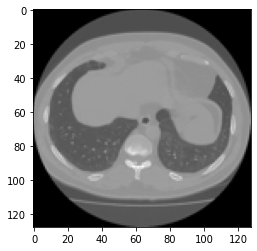

이미지 크기: (128, 128)


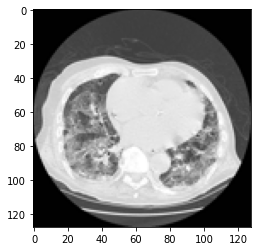

In [ ]:
image = Image.open('/content/drive/MyDrive/Colab Notebooks/ncc_GAN/LargeCovidCT_images/curated_data/curated_data/1NonCOVID/16_Morozov_study_0001_12.png')
print("이미지 크기:", image.size)

plt.imshow(image, cmap='gray')
plt.show()

# disease
image = Image.open('/content/drive/MyDrive/Colab Notebooks/ncc_GAN/LargeCovidCT_images/curated_data/curated_data/2COVID/13_Bjorke_1.png')
print("이미지 크기:", image.size)

plt.imshow(image, cmap='gray')
plt.show()

In [ ]:
import os.path

#original_path = '/content/drive/MyDrive/Colab Notebooks/ncc_GAN/LargeCovidCT_images/curated_data/curated_data/2COVID/'

files = glob.glob('/content/drive/MyDrive/Colab Notebooks/ncc_GAN/LargeCovidCT_images/curated_data/curated_data/1NonCOVID/*.png')

for f in files:
    title, ext = os.path.splitext(f)
    if ext in ['.png']:
        img = Image.open(f)
        img_resize = img.resize((128, 128))
        img_resize.save(title+ext)

이미지 크기: (128, 128)


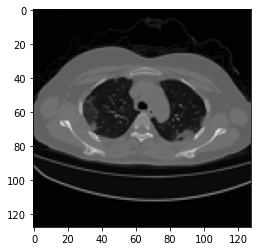

In [ ]:
image = Image.open('/content/drive/MyDrive/Colab Notebooks/ncc_GAN/LargeCovidCT_images/curated_data/curated_data/2COVID/14_Jun_coronacases_case10_224.png')
print("이미지 크기:", image.size)

plt.imshow(image, cmap='gray')
plt.show()

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None):
        self.transform = transforms_

        self.files = sorted(glob.glob(os.path.join('/content/drive/MyDrive/Colab Notebooks/ncc_GAN/LargeCovidCT_images/curated_data/curated_data/', f"1NonCOVID") + "/*.png"))

    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)])
        img = self.transform(img)

        return img

    def __len__(self):
        return len(self.files)

In [ ]:
transforms_ = transforms.Compose([
    transforms.Resize((64, 64), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = ImageDataset("/content/drive/MyDrive/Colab Notebooks/ncc_GAN/LargeCovidCT_images/curated_data/curated_data/1NonCOVID",transforms_=transforms_)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=4)

In [ ]:
latent_dim = 100



class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = 4 
        self.layer1 = nn.Sequential(nn.Linear(latent_dim, 512 * self.init_size * self.init_size)) 

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(512), 
            nn.Upsample(scale_factor=2), 
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1), 
            nn.Tanh(),
        )

    def forward(self, z):
        output = self.layer1(z)
        output = output.view(output.size(0), 512, self.init_size, self.init_size)
        output = self.conv_blocks(output)
        return output

In [ ]:

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def make_block(in_channels, out_channels, bn=True):
            
            block = [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)]
            block.append(nn.LeakyReLU(0.2, inplace=True))
            block.append(nn.Dropout2d(0.25))
            if bn:
                block.append(nn.BatchNorm2d(out_channels, 0.8))
            return block

        self.conv_blocks = nn.Sequential(
            *make_block(1, 32, bn=False),
            *make_block(32, 64),
            *make_block(64, 128),
            *make_block(128, 256),
            *make_block(256, 512),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 1),
            nn.Sigmoid()
        )


    def forward(self, img):
        output = self.conv_blocks(img)
        output = output.view(output.size(0), -1)
        output = self.classifier(output)
        return output

In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


generator = Generator()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()


generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)


adversarial_loss = nn.BCELoss()
adversarial_loss.cuda()


lr = 0.0002


optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [ ]:
import time

n_epochs = 200 
sample_interval = 500 
start_time = time.time()

for epoch in range(n_epochs):
    for i, imgs in enumerate(dataloader):

        
        real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0) 
        fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0) 

        real_imgs = imgs.cuda()

        
        optimizer_G.zero_grad()

        
        z = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).cuda()

        
        generated_imgs = generator(z)

        
        g_loss = adversarial_loss(discriminator(generated_imgs), real)

    
        g_loss.backward()
        optimizer_G.step()

        
        optimizer_D.zero_grad()

        
        real_loss = adversarial_loss(discriminator(real_imgs), real)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

       
        d_loss.backward()
        optimizer_D.step()

        done = epoch * len(dataloader) + i
        if done % sample_interval == 0:
            
            save_image(generated_imgs.data[:25], f"{done}.png", nrow=5, normalize=True)

    
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")


[Epoch 0/200] [D loss: 0.597643] [G loss: 0.927201] [Elapsed time: 17.78s]
[Epoch 1/200] [D loss: 0.518493] [G loss: 0.770328] [Elapsed time: 28.44s]
[Epoch 2/200] [D loss: 0.634621] [G loss: 0.795443] [Elapsed time: 38.85s]
[Epoch 3/200] [D loss: 0.391856] [G loss: 1.148947] [Elapsed time: 49.17s]
[Epoch 4/200] [D loss: 0.698528] [G loss: 0.815202] [Elapsed time: 59.31s]
[Epoch 5/200] [D loss: 0.711581] [G loss: 0.835020] [Elapsed time: 69.42s]
[Epoch 6/200] [D loss: 0.759970] [G loss: 0.575879] [Elapsed time: 79.51s]
[Epoch 7/200] [D loss: 0.506943] [G loss: 1.043464] [Elapsed time: 89.67s]
[Epoch 8/200] [D loss: 0.571949] [G loss: 0.751055] [Elapsed time: 99.94s]
[Epoch 9/200] [D loss: 0.604783] [G loss: 1.549049] [Elapsed time: 110.31s]
[Epoch 10/200] [D loss: 0.504780] [G loss: 0.749872] [Elapsed time: 120.65s]
[Epoch 11/200] [D loss: 0.405598] [G loss: 1.036750] [Elapsed time: 131.01s]
[Epoch 12/200] [D loss: 0.415563] [G loss: 1.108398] [Elapsed time: 141.32s]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe181004830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


[Epoch 13/200] [D loss: 0.689567] [G loss: 1.297119] [Elapsed time: 151.55s]
[Epoch 14/200] [D loss: 0.459047] [G loss: 2.050169] [Elapsed time: 161.74s]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe181004830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe181004830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

[Epoch 15/200] [D loss: 0.488685] [G loss: 0.904687] [Elapsed time: 172.02s]
[Epoch 16/200] [D loss: 0.556817] [G loss: 1.006197] [Elapsed time: 182.25s]
[Epoch 17/200] [D loss: 0.483501] [G loss: 1.989710] [Elapsed time: 192.49s]
[Epoch 18/200] [D loss: 0.469399] [G loss: 2.153914] [Elapsed time: 202.78s]
[Epoch 19/200] [D loss: 0.411615] [G loss: 2.108146] [Elapsed time: 213.10s]
[Epoch 20/200] [D loss: 0.550706] [G loss: 0.924721] [Elapsed time: 223.41s]
[Epoch 21/200] [D loss: 0.299255] [G loss: 1.876549] [Elapsed time: 233.70s]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe181004830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe181004830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

[Epoch 22/200] [D loss: 0.422506] [G loss: 0.816929] [Elapsed time: 243.98s]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe181004830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe181004830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

[Epoch 23/200] [D loss: 0.342572] [G loss: 1.685194] [Elapsed time: 254.27s]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe181004830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child processException ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fe181004830>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fe181004830>    
self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3

[Epoch 24/200] [D loss: 0.450881] [G loss: 1.021519] [Elapsed time: 264.53s]
[Epoch 25/200] [D loss: 0.801471] [G loss: 0.197453] [Elapsed time: 274.79s]
[Epoch 26/200] [D loss: 0.389067] [G loss: 1.641662] [Elapsed time: 285.04s]
[Epoch 27/200] [D loss: 0.184600] [G loss: 1.773148] [Elapsed time: 295.37s]
[Epoch 28/200] [D loss: 0.184728] [G loss: 1.763055] [Elapsed time: 305.60s]
[Epoch 29/200] [D loss: 0.232039] [G loss: 2.245759] [Elapsed time: 315.83s]
[Epoch 30/200] [D loss: 0.347643] [G loss: 0.922342] [Elapsed time: 326.08s]
[Epoch 31/200] [D loss: 0.182340] [G loss: 1.404715] [Elapsed time: 336.36s]
[Epoch 32/200] [D loss: 0.190070] [G loss: 2.273371] [Elapsed time: 346.59s]
[Epoch 33/200] [D loss: 0.188060] [G loss: 2.078509] [Elapsed time: 356.84s]
[Epoch 34/200] [D loss: 0.411868] [G loss: 3.622702] [Elapsed time: 367.08s]
[Epoch 35/200] [D loss: 0.091874] [G loss: 2.143962] [Elapsed time: 377.36s]
[Epoch 36/200] [D loss: 0.125579] [G loss: 1.772133] [Elapsed time: 387.71s]

In [ ]:
from IPython.display import Image

In [ ]:
torch.save(generator.state_dict(), "Upsampling_DCGAN_Generator_normal_lungCT.pt")
torch.save(discriminator.state_dict(), "Upsampling_DCGAN_Discriminator_normal_lungCT.pt")
print("Model saved!")

Model saved!


In [ ]:
from google.colab import files

files.download('Upsampling_DCGAN_Generator_normal_lungCT.pt')
files.download('Upsampling_DCGAN_Discriminator_normal_lungCT.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!wget https://drive.google.com/file/d/11zvGxRbcauQ8xvVHI8lUL3c_DxOnh8MX/view?usp=sharing
!wget https://drive.google.com/file/d/1kwlm2qA9__2UV_8eIZNEP77UYeb_R9Zt/view?usp=sharing

--2022-10-15 07:11:18--  https://drive.google.com/file/d/11zvGxRbcauQ8xvVHI8lUL3c_DxOnh8MX/view?usp=sharing
Resolving drive.google.com (drive.google.com)... 142.250.157.138, 142.250.157.101, 142.250.157.100, ...
Connecting to drive.google.com (drive.google.com)|142.250.157.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://accounts.google.com/ServiceLogin?service=wise&passive=1209600&osid=1&continue=https://drive.google.com/file/d/11zvGxRbcauQ8xvVHI8lUL3c_DxOnh8MX/view?usp%3Dsharing&followup=https://drive.google.com/file/d/11zvGxRbcauQ8xvVHI8lUL3c_DxOnh8MX/view?usp%3Dsharing [following]
--2022-10-15 07:11:18--  https://accounts.google.com/ServiceLogin?service=wise&passive=1209600&osid=1&continue=https://drive.google.com/file/d/11zvGxRbcauQ8xvVHI8lUL3c_DxOnh8MX/view?usp%3Dsharing&followup=https://drive.google.com/file/d/11zvGxRbcauQ8xvVHI8lUL3c_DxOnh8MX/view?usp%3Dsharing
Resolving accounts.google.com (accounts.google.com)... 108.177.1

In [ ]:
generator = Generator()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

generator.load_state_dict(torch.load("Upsampling_DCGAN_Generator_normal_lungCT.pt"))
discriminator.load_state_dict(torch.load("Upsampling_DCGAN_Discriminator_normal_lungCT.pt"))

generator.eval();
discriminator.eval();

In [ ]:

z = torch.normal(mean=0, std=1, size=(100, latent_dim)).cuda()


generated_imgs = generator(z)


save_image(generated_imgs.data[:100], f"result.png", nrow=10, normalize=True)

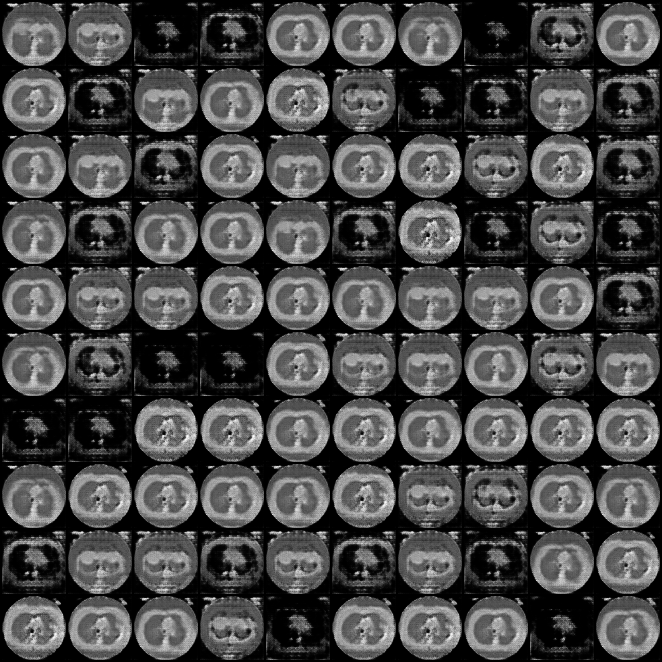

In [ ]:
from IPython.display import Image

Image('result.png')

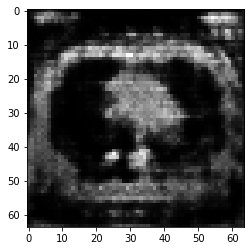

In [ ]:
generated_img = generator(lung_CT1).detach().cpu()
plt.imshow(generated_img.squeeze(0).permute(1, 2, 0).squeeze(2), cmap='gray')
plt.show()

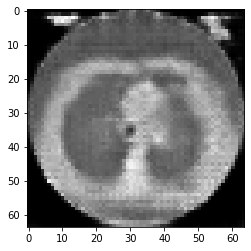

In [ ]:
generated_img = generator(lung_CT2).detach().cpu()
plt.imshow(generated_img.squeeze(0).permute(1, 2, 0).squeeze(2), cmap='gray')
plt.show()

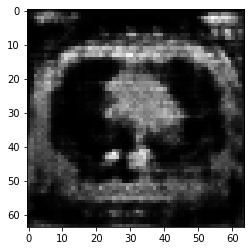

In [ ]:
generated_img = generator(lung_CT3).detach().cpu()
plt.imshow(generated_img.squeeze(0).permute(1, 2, 0).squeeze(2), cmap='gray')
plt.show()

In [ ]:
lungct_left = z[70].unsqueeze(0)
lungct_right = z[19].unsqueeze(0)

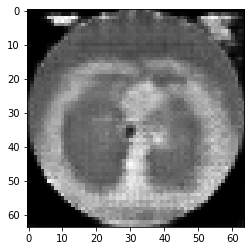

In [ ]:
generated_img = generator(lungct_left).detach().cpu()
plt.imshow(generated_img.squeeze(0).permute(1, 2, 0).squeeze(2), cmap='gray')
plt.show()


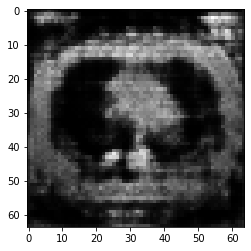

In [ ]:
generated_img = generator(lungct_right).detach().cpu()
plt.imshow(generated_img.squeeze(0).permute(1, 2, 0).squeeze(2), cmap='gray')
plt.show()

In [ ]:
current = torch.Tensor(size=(10, 100)).cuda()
for i in range(10):
    current[i] = (lungct_left.squeeze(0) * (i / 9) + lungct_right.squeeze(0) * ((9 - i) / 9))


generated_imgs = generator(current).detach().cpu()
save_image(generated_imgs.data, f"interpolation.png", nrow=10, normalize=True)

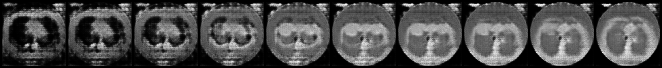

In [ ]:
from IPython.display import Image

Image('interpolation.png')